In [1]:
import os
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras import models, regularizers, optimizers, losses
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, Input
from keras.utils import to_categorical
from keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn import metrics

In [3]:
vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
main_path = "C:/Users/lenovo/OneDrive/Pulpit/Python/Neural-Networks/datasets/dogvscat_small"

if not os.path.exists(main_path + '/train/trainset'):
    os.mkdir(main_path + '/train/trainset')
if not os.path.exists(main_path + '/test/testset'):
    os.mkdir(main_path + '/test/testset')
if not os.path.exists(main_path + '/validation/valset'):
    os.mkdir(main_path + '/validation/valset')

for path in os.listdir(main_path + "/train/cats/"):
    src = main_path + "/train/cats/" + path
    dst = main_path + "/train/trainset/" + path
    shutil.copyfile(src, dst)
for path in os.listdir(main_path + "/train/dogs/"):
    src = main_path + "/train/dogs/" + path
    dst = main_path + "/train/trainset/_" + path
    shutil.copyfile(src, dst)

for path in os.listdir(main_path + "/test/cats/"):
    src = main_path + "/test/cats/" + path
    dst = main_path + "/test/testset/" + path
    shutil.copyfile(src, dst)
for path in os.listdir(main_path + "/test/dogs/"):
    src = main_path + "/test/dogs/" + path
    dst = main_path + "/test/testset/_" + path
    shutil.copyfile(src, dst)

for path in os.listdir(main_path + "/validation/cats/"):
    src = main_path + "/validation/cats/" + path
    dst = main_path + "/validation/valset/" + path
    shutil.copyfile(src, dst)
for path in os.listdir(main_path + "/validation/dogs/"):
    src = main_path + "/validation/dogs/" + path
    dst = main_path + "/validation/valset/_" + path
    shutil.copyfile(src, dst)

In [38]:
main_path = "C:/Users/lenovo/OneDrive/Pulpit/Python/Neural-Networks/datasets/dogvscat_small"
train_dir = os.path.join(main_path, 'train')
validation_dir = os.path.join(main_path, 'validation')
test_dir = os.path.join(main_path, 'test')

img_rows, img_cols = 150, 150

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_rows, img_cols),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_rows, img_cols),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [39]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


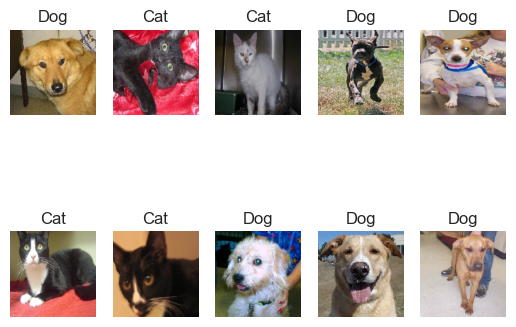

In [44]:
i = 0
plt.figure()
for data_batch, labels_batch in train_generator:
    plt.subplot(2, 5, i+1)
    plt.imshow(data_batch[i])
    plt.axis('off')
    plt.title('Dog' if labels_batch[i] else "Cat")
    i += 1

    if i == 10:
        break


In [45]:
model = models.Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

Feature extraction:

In [47]:
vgg16.trainable = False

epochs = 20
batch_size = 32
opt = optimizers.RMSprop(0.001)
loss = losses.binary_crossentropy

model.compile(loss=loss,
              optimizer=opt,
              metrics=['acc']
              )

In [48]:
history = model.fit(train_generator,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    verbose=1
                    )

C:\Users\lenovo\OneDrive\Pulpit\Python\Neural-Networks\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - acc: 0.7420 - loss: 0.8089 - val_acc: 0.8940 - val_loss: 0.2941
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - acc: 0.8580 - loss: 0.3215 - val_acc: 0.8960 - val_loss: 0.2551
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - acc: 0.8915 - loss: 0.2662 - val_acc: 0.8710 - val_loss: 0.3208
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - acc: 0.9150 - loss: 0.2163 - val_acc: 0.8670 - val_loss: 0.3201
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - acc: 0.9325 - loss: 0.1729 - val_acc: 0.9060 - val_loss: 0.2514
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - acc: 0.9415 - loss: 0.1479 - val_acc: 0.9020 - val_loss: 0.2625
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - acc: 0.9560 - loss: 0.1116 - val_acc: 0.8460 - val_loss: 0.4138
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - acc: 0.9590 - loss: 0.1096 - val_acc: 0.8970 - val_loss: 0.2819
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - acc: 0.9670 - loss: 

In [57]:
score = model.evaluate(test_generator, steps=50)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 801ms/step - acc: 0.9994 - loss: 0.0087
Test loss: 0.008660681545734406
Test accuracy: 0.9993749856948853


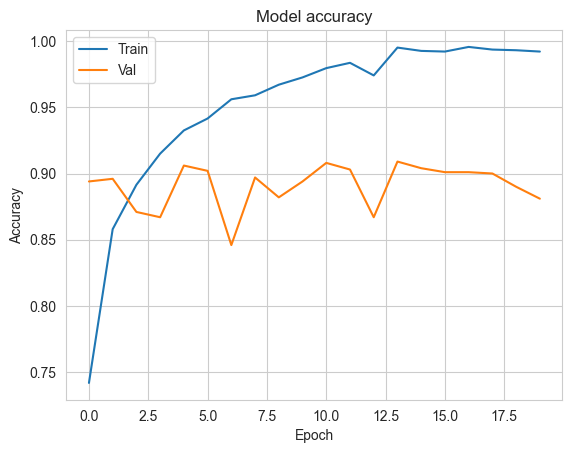

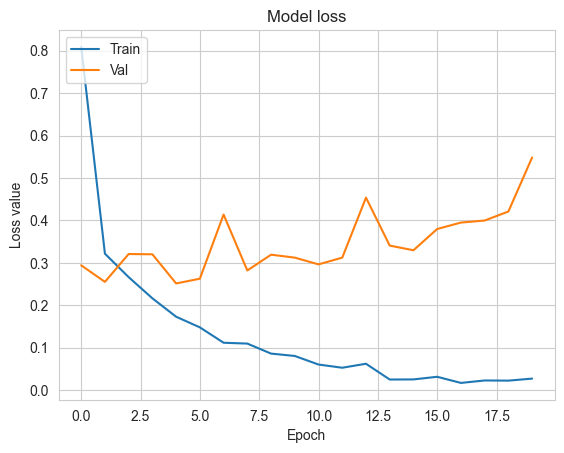

In [52]:
acc = history.history['acc']
loss = history.history['loss']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.figure()
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Fine tuning:

In [2]:
vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
main_path = "C:/Users/lenovo/OneDrive/Pulpit/Python/Neural-Networks/datasets/dogvscat_small"
train_dir = os.path.join(main_path, 'train')
validation_dir = os.path.join(main_path, 'validation')
test_dir = os.path.join(main_path, 'test')

img_rows, img_cols = 150, 150

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_rows, img_cols),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_rows, img_cols),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_rows, img_cols),
    color_mode='rgb',
    batch_size=32,
    shuffle=True,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [4]:
model = models.Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
vgg16.trainable = True
print(len(model.trainable_weights))

for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
    else:
        layer.trainable = False

print(len(model.trainable_weights))

30
6


In [6]:
epochs = 20
batch_size = 32
opt = optimizers.RMSprop(0.001)
loss = losses.binary_crossentropy

model.compile(loss=loss,
              optimizer=opt,
              metrics=['acc']
              )

In [7]:
history = model.fit(train_generator,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=validation_generator,
                    verbose=1
                    )

C:\Users\lenovo\OneDrive\Pulpit\Python\Neural-Networks\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - acc: 0.6670 - loss: 0.8719 - val_acc: 0.8260 - val_loss: 0.4037
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - acc: 0.8330 - loss: 0.3909 - val_acc: 0.8760 - val_loss: 0.2808
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - acc: 0.8880 - loss: 0.2661 - val_acc: 0.8990 - val_loss: 0.2515
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - acc: 0.9110 - loss: 0.2154 - val_acc: 0.8600 - val_loss: 0.3607
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - acc: 0.9500 - loss: 0.1361 - val_acc: 0.8590 - val_loss: 0.4408
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - acc: 0.9535 - loss: 0.1110 - val_acc: 0.9020 - val_loss: 0.2757
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - acc: 0.9720 - loss: 0.0835 - val_acc: 0.8810 - val_loss: 0.3813
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - acc: 0.9810 - loss: 0.0567 - val_acc: 0.8940 - val_loss: 0.4684
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - acc: 0.9815 - lo

In [8]:
score = model.evaluate(test_generator, steps=50)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 946ms/step - acc: 0.9981 - loss: 0.0060
Test loss: 0.006019206717610359
Test accuracy: 0.9981250166893005


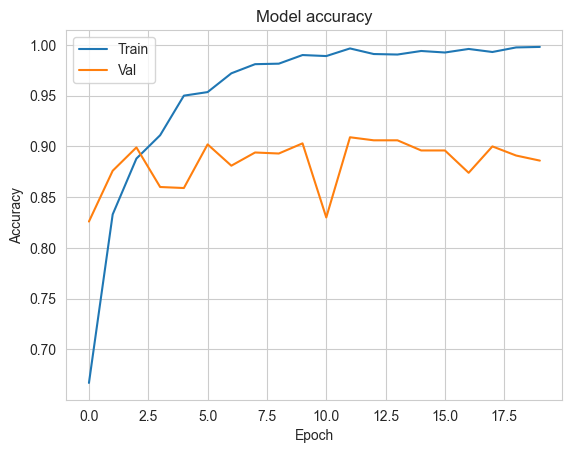

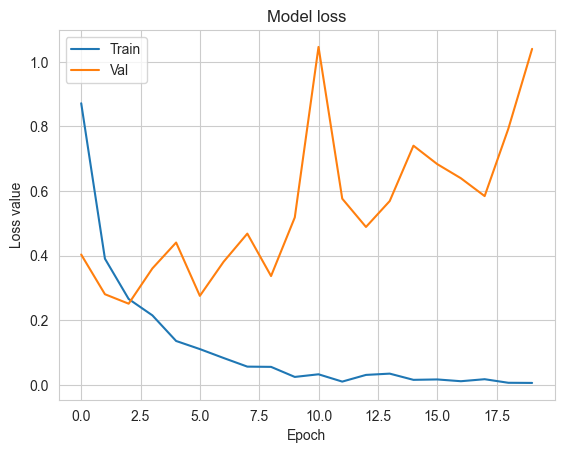

In [9]:
acc = history.history['acc']
loss = history.history['loss']

val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.figure()
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()